# 0. Configuration and Imports

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import cv2
import os

VIDEO_FILE = 'Videos/Crochet_Vid.mp4'
FRAME_DIR = 'frames'
TARGET_FPS = 3
MAX_IMAGES_PER_SEQUENCE = 200

FEATURE_ALGORITHMS = {
    "ORB": cv2.ORB_create(nfeatures=2000),
    "SIFT": cv2.SIFT_create(),
    "BRISK": cv2.BRISK_create()
}

MATCHING_ALGORITHM = "SIFT"  # Options: "ORB", "SIFT", "BRISK"
LOWES_RATIO = 0.75
MIN_INLIER_COUNT = 15

OUTPUT_KEYPOINTS_DIR = "output_keypoints"
OUTPUT_ANALYSIS_DIR  = "output_analysis"
OUTPUT_MATCHES_DIR   = "output_matches"
OUTPUT_SCENE_DIR     = "output_scene"

# 2. Frame Extraction

In [32]:
print("\n STEP 2: FRAME EXTRACTION\n")

def extract_frames(video_path, output_dir, target_fps):
    if not os.path.exists(output_dir): 
        os.makedirs(output_dir)

    video = cv2.VideoCapture(video_path)

    if not video.isOpened(): 
        print(f"Error: Could not open video file {video_path}"); 
        return
    video_fps = video.get(cv2.CAP_PROP_FPS) or 30; frame_interval = int(round(video_fps / target_fps))
    saved_count, frame_index = 0, 0

    while True:
        ret, frame = video.read();
        if not ret: break
        if frame_index % frame_interval == 0: cv2.imwrite(os.path.join(output_dir, f"frame_{saved_count:04d}.jpg"), frame); saved_count += 1
        frame_index += 1

    video.release()
    print(f"Extraction complete. {saved_count} frames saved to '{output_dir}'.\n")

sequence_name = os.path.splitext(os.path.basename(VIDEO_FILE))[0]
output_sequence_dir = os.path.join(FRAME_DIR, sequence_name)

if not os.path.isdir(output_sequence_dir) or not os.listdir(output_sequence_dir): 
    extract_frames(VIDEO_FILE, output_sequence_dir, TARGET_FPS)
else: 
    print(f"Frames already exist in '{output_sequence_dir}', skipping extraction.\n")


 STEP 2: FRAME EXTRACTION

Frames already exist in 'frames/Figure_Vid', skipping extraction.



# 3. Feature Detection and Description

In [33]:
print("\n STEP 3: FEATURE DETECTION \n")

def load_images_for_one_video(video_folder_path, max_images=None):
    images_data = []
    filenames = sorted([f for f in os.listdir(video_folder_path) if f.lower().endswith(('.jpg', '.png'))])
    files_to_load = filenames[:max_images] if max_images is not None else filenames
    for filename in files_to_load:
        img_path = os.path.join(video_folder_path, filename); img_color = cv2.imread(img_path)
        if img_color is None: continue
        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        images_data.append({'filename': filename, 'image_color': img_color, 'image_gray': img_gray})
    return images_data

def detect_features(detector, images_data, alg_name, sequence_name):
    results = []
    keypoints_out_dir = os.path.join(OUTPUT_KEYPOINTS_DIR, sequence_name, alg_name)
    if not os.path.exists(keypoints_out_dir): os.makedirs(keypoints_out_dir)
    
    print(f"-> Saving keypoint visualizations for {alg_name} to '{keypoints_out_dir}'...")
    
    for data in images_data:
        start_time = time.time()
        keypoints, descriptors = detector.detectAndCompute(data['image_gray'], None)
        detection_time = time.time() - start_time
        
        # Draw and save keypoints for EVERY frame
        img_with_keypoints = cv2.drawKeypoints(data['image_color'], keypoints, None, color=(0, 255, 0), flags=0)
        out_path = os.path.join(keypoints_out_dir, f"{os.path.splitext(data['filename'])[0]}_keypoints.jpg")
        cv2.imwrite(out_path, img_with_keypoints)
            
        results.append({
            'filename': data['filename'], 'image': data['image_color'],
            'keypoints': keypoints, 'descriptors': descriptors,
            'detection_time': detection_time
        })
    return results

all_images_data = load_images_for_one_video(output_sequence_dir, max_images=MAX_IMAGES_PER_SEQUENCE)
all_feature_results = []

for alg_name, detector in FEATURE_ALGORITHMS.items():
    print(f"Detecting features with {alg_name}...")
    feature_results = detect_features(detector, all_images_data, alg_name, sequence_name)
    for res in feature_results: res['algorithm'] = alg_name
    all_feature_results.extend(feature_results)

results_df = pd.DataFrame(all_feature_results)

print("Feature detection complete.\n")

# VISUALISATION STEP
if not os.path.exists(OUTPUT_ANALYSIS_DIR): 
    os.makedirs(OUTPUT_ANALYSIS_DIR)

# Calculate keypoint counts for each frame/algorithm
results_df['keypoint_count'] = results_df['keypoints'].apply(lambda kp: len(kp) if kp is not None else 0)

# Group by algorithm and calculate average keypoints and time
analysis_df = results_df.groupby('algorithm').agg(
    avg_keypoints=('keypoint_count', 'mean'),
    avg_time=('detection_time', 'mean')
).reset_index()

print("Feature Detection Performance Analysis:")
print(analysis_df)

# Plot 1: Average Keypoints Detected per Frame
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
plt.bar(analysis_df['algorithm'], analysis_df['avg_keypoints'], color=colors[:len(analysis_df)])
plt.title(f'Average Keypoints Detected per Frame ({sequence_name})', fontsize=16)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Average Number of Keypoints', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
keypoint_plot_path = os.path.join(OUTPUT_ANALYSIS_DIR, f"{sequence_name}_avg_keypoints.png")
plt.savefig(keypoint_plot_path)
plt.close()

# Plot 2: Average Detection Time per Frame
plt.figure(figsize=(10, 6))
plt.bar(analysis_df['algorithm'], analysis_df['avg_time'], color=colors[:len(analysis_df)])
plt.title(f'Average Detection Time per Frame ({sequence_name})', fontsize=16)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Average Time (seconds)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
time_plot_path = os.path.join(OUTPUT_ANALYSIS_DIR, f"{sequence_name}_avg_time.png")
plt.savefig(time_plot_path)
plt.close()

print(f"\nAnalysis plots saved to '{OUTPUT_ANALYSIS_DIR}'.\n")


 STEP 3: FEATURE DETECTION 

Detecting features with ORB...
-> Saving keypoint visualizations for ORB to 'output_keypoints/Figure_Vid/ORB'...
Detecting features with SIFT...
-> Saving keypoint visualizations for SIFT to 'output_keypoints/Figure_Vid/SIFT'...
Detecting features with BRISK...
-> Saving keypoint visualizations for BRISK to 'output_keypoints/Figure_Vid/BRISK'...
Feature detection complete.

Feature Detection Performance Analysis:
  algorithm  avg_keypoints  avg_time
0     BRISK     520.705882  0.014310
1       ORB    1413.676471  0.005012
2      SIFT     307.529412  0.035896

Analysis plots saved to 'output_analysis'.



# 4/5. Feature Matching and Outlier Rejection + Fundamental Matrix Computation

In [34]:
print("\n STEP 4 & 5: MATCHING & MATRIX COMPUTATION \n")

def match_and_filter_features(data1, data2, alg_name):
    kp1, des1 = data1['keypoints'], data1['descriptors']
    kp2, des2 = data2['keypoints'], data2['descriptors']

    # Skip if not enough descriptors
    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        return [], [], None, None

    # Select matching strategy based on algorithm
    if alg_name in ["SIFT", "BRISK"]:
        matcher = cv2.BFMatcher(cv2.NORM_L2)
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in raw_matches if m.distance < LOWES_RATIO * n.distance]
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        good_matches = sorted(matcher.match(des1, des2), key=lambda x: x.distance)

    # Skip if not enough good matches
    if len(good_matches) < MIN_INLIER_COUNT:
        return good_matches, [], None, None

    # Extract point coordinates from matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 2.0)

    # Filter inliers
    inliers = [m for i, m in enumerate(good_matches) if mask is not None and mask.ravel()[i]]

    return good_matches, inliers, F, mask


def draw_matches(data1, data2, matches, mask, sequence_name, alg_name, stage):
    output_dir = os.path.join(OUTPUT_MATCHES_DIR, sequence_name, alg_name)
    os.makedirs(output_dir, exist_ok=True)

    match_mask = mask.ravel().tolist() if mask is not None else None
    img_matches = cv2.drawMatches(
        data1['image'], data1['keypoints'],
        data2['image'], data2['keypoints'],
        matches, None,
        matchesMask=match_mask,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    filename = f"{os.path.splitext(data1['filename'])[0]}_" \
               f"{os.path.splitext(data2['filename'])[0]}_{stage}.jpg"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, img_matches)


# Filter results by the selected matching algorithm
sequence_df = results_df[results_df['algorithm'] == MATCHING_ALGORITHM].reset_index(drop=True)

# Process image pairs and compute fundamental matrices
all_processed_pairs = []

for i in range(len(sequence_df) - 1):
    data1 = sequence_df.iloc[i]
    data2 = sequence_df.iloc[i + 1]

    raw_matches, inliers, F, mask = match_and_filter_features(data1, data2, MATCHING_ALGORITHM)

    if len(inliers) >= MIN_INLIER_COUNT:
        draw_matches(data1, data2, raw_matches, mask, sequence_name, MATCHING_ALGORITHM, stage="after_ransac")

        all_processed_pairs.append({
            'data1': data1,
            'data2': data2,
            'inliers': inliers,
            'F': F
        })

print(f"Found {len(all_processed_pairs)} valid pairs for reconstruction.\n")


 STEP 4 & 5: MATCHING & MATRIX COMPUTATION 

Found 33 valid pairs for reconstruction.



# 6. Camera Positions Estimation

In [35]:
print("\n STEP 6: CAMERA POSE ESTIMATION \n")

# Assume focal length equals image width, and principal point is image center
h, w = all_images_data[0]['image_color'].shape[:2]
focal_length = w
K = np.array([
    [focal_length, 0, w / 2],
    [0, focal_length, h / 2],
    [0, 0, 1]
], dtype=np.float32)

print("Using assumed Camera Matrix (K):\n", K)

# Check if we have valid pairs to estimate pose
if not all_processed_pairs:
    print("No valid pairs found to estimate pose.")
else:
    for i, pair_data in enumerate(all_processed_pairs):
        F = pair_data['F']
        inliers = pair_data['inliers']
        kp1 = pair_data['data1']['keypoints']
        kp2 = pair_data['data2']['keypoints']

        # Extract matched inlier points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers])

        # Compute essential matrix from fundamental matrix and camera intrinsics
        E = K.T @ F @ K

        # Recover relative camera pose (rotation R and translation t)
        retval, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

        if retval > 0:
            all_processed_pairs[i]['R'] = R
            all_processed_pairs[i]['t'] = t
            all_processed_pairs[i]['pose_inliers'] = mask_pose
        else:
            all_processed_pairs[i]['R'] = None
            all_processed_pairs[i]['t'] = None

print("\nPose estimation complete.\n")


 STEP 6: CAMERA POSE ESTIMATION 

Using assumed Camera Matrix (K):
 [[478.   0. 239.]
 [  0. 478. 425.]
 [  0.   0.   1.]]

Pose estimation complete.



# 7. 3D Point Triangulation and Scene Visualisation


 STEP 7: TRIANGULATION, FILTERING & VISUALISATION

Triangulated a total of 2530 points.
Total camera poses estimated: 33
Filtering: Kept 2504 of 2530 points.

Visualizing the filtered 3D scene...


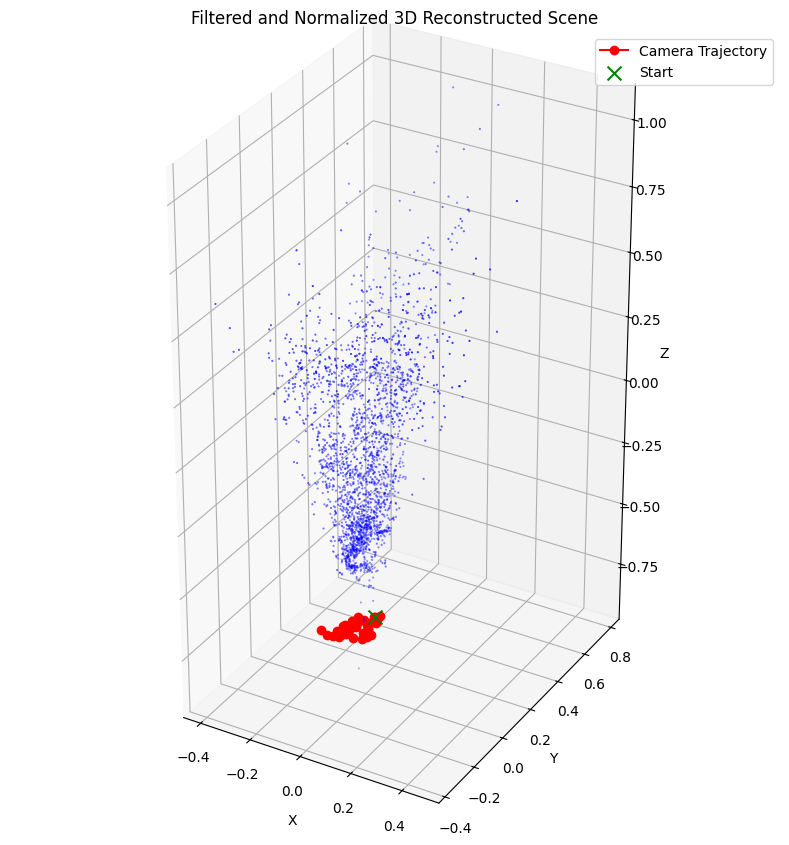


Full pipeline complete.


In [ ]:
print("\n STEP 7: TRIANGULATION, FILTERING & VISUALISATION\n")

def filter_point_cloud(points_3d, k_neighbors=20, std_ratio=1.0):
    if points_3d.shape[0] < k_neighbors:
        print("Warning: Not enough points for filtering. Returning original cloud.")
        return points_3d

    # Use FLANN for fast nearest neighbor search
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    points_flat = points_3d.astype(np.float32)

    # Find the k+1 nearest neighbors (the first is the point itself)
    matches = flann.knnMatch(points_flat, points_flat, k=k_neighbors + 1)

    mean_distances = []
    for i in range(len(matches)):
        distances = [m.distance for m in matches[i][1:]]
        if distances:
            mean_distances.append(np.mean(distances))
        else:
            mean_distances.append(0) # Handle case with no neighbors

    mean_distances = np.array(mean_distances)

    global_mean_dist = np.mean(mean_distances)
    global_std_dist = np.std(mean_distances)

    distance_threshold = global_mean_dist + std_ratio * global_std_dist

    inlier_mask = mean_distances < distance_threshold

    print(f"Filtering: Kept {np.sum(inlier_mask)} of {len(points_3d)} points.")

    return points_3d[inlier_mask]

# Initialize scene elements
camera_poses = []
points_3d = np.empty((0, 3))

# The first camera is at the origin [R|t] = [I|0]
R_global = np.identity(3)
t_global = np.zeros((3, 1))
camera_poses.append(np.hstack((R_global, t_global)))

# Process each valid pair to triangulate points and chain poses
for pair in all_processed_pairs:
    if pair.get('R') is None or pair.get('t') is None:
        continue # Skip pairs where pose estimation failed

    # The pose of the first camera in the pair is the last one we successfully calculated
    R_cam1, t_cam1 = camera_poses[-1][:, :3], camera_poses[-1][:, 3].reshape(3, 1)

    R_relative, t_relative = pair['R'], pair['t']

    # Update global pose for the second camera in the pair
    R_cam2 = R_cam1 @ R_relative
    t_cam2 = t_cam1 + R_cam1 @ t_relative

    pose_cam2 = np.hstack((R_cam2, t_cam2))
    camera_poses.append(pose_cam2)

    # Get the 2D points for triangulation
    kp1, kp2 = pair['data1']['keypoints'], pair['data2']['keypoints']
    inliers = pair['inliers']

    # Filter points further by the chirality check mask from `recoverPose`
    pose_mask = pair.get('pose_inliers')
    if pose_mask is not None:
        inliers = [m for i, m in enumerate(inliers) if pose_mask.ravel()[i]]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers]).T
    pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers]).T

    if pts1.shape[1] == 0 or pts2.shape[1] == 0:
        continue # No points left to triangulate for this pair

    # Create projection matrices for triangulation
    P1 = K @ camera_poses[-2] # The second to last pose
    P2 = K @ camera_poses[-1] # The last pose

    # Triangulate 3D points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1, pts2)

    # Convert from homogeneous to 3D coordinates
    points_3d_new = (points_4d_hom[:3, :] / points_4d_hom[3, :]).T
    points_3d = np.vstack((points_3d, points_3d_new))


print(f"Triangulated a total of {points_3d.shape[0]} points.")
print(f"Total camera poses estimated: {len(camera_poses)}")

# Filter the final point cloud to remove outliers
if points_3d.shape[0] > 0:
    points_3d_filtered = filter_point_cloud(points_3d, k_neighbors=30, std_ratio=0.5)
else:
    points_3d_filtered = points_3d # Keep it as an empty array


# Visualize the 3D Scene with Plotly for interactivity
if points_3d_filtered.shape[0] > 0:
    print("\nVisualizing the filtered 3D scene (interactive)...")
    if not os.path.exists(OUTPUT_SCENE_DIR): os.makedirs(OUTPUT_SCENE_DIR)

    # The camera's 3D position is derived from its pose matrix [R|t] as -R.T @ t
    cam_positions = np.array([-pose[:, :3].T @ pose[:, 3] for pose in camera_poses])

    # NORMALIZATION FOR BETTER VISUALIZATION
    mean_point = points_3d_filtered.mean(axis=0)
    points_centered = points_3d_filtered - mean_point
    cams_centered = cam_positions - mean_point
    max_abs_coord = np.max(np.abs(points_centered))
    if max_abs_coord == 0: max_abs_coord = 1 # Avoid division by zero
    points_normalized = points_centered / max_abs_coord
    cams_normalized = cams_centered / max_abs_coord

    # Create the figure
    fig = go.Figure()

    # Add the 3D point cloud
    fig.add_trace(go.Scatter3d(
        x=points_normalized[:, 0],
        y=points_normalized[:, 1],
        z=points_normalized[:, 2],
        mode='markers',
        marker=dict(size=1, color='blue'),
        name='Point Cloud'
    ))

    # Add the camera trajectory
    fig.add_trace(go.Scatter3d(
        x=cams_normalized[:, 0],
        y=cams_normalized[:, 1],
        z=cams_normalized[:, 2],
        mode='lines+markers',
        line=dict(color='red', width=5),
        marker=dict(size=4, color='red'),
        name='Camera Trajectory'
    ))

    # Add the start point
    fig.add_trace(go.Scatter3d(
        x=[cams_normalized[0, 0]],
        y=[cams_normalized[0, 1]],
        z=[cams_normalized[0, 2]],
        mode='markers',
        marker=dict(size=8, color='green', symbol='x'),
        name='Start'
    ))

    # Update the layout
    fig.update_layout(
        title_text='Filtered and Normalized 3D Reconstructed Scene (Interactive)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Save to an interactive HTML file
    interactive_plot_path = os.path.join(OUTPUT_SCENE_DIR, f"{sequence_name}_3d_reconstruction_interactive.html")
    fig.write_html(interactive_plot_path)

    # Show the figure
    fig.show()
    print(f"\nInteractive plot saved to '{interactive_plot_path}'")

else:
    print("\nNo 3D points were reconstructed or all points were filtered out. Cannot visualize scene.")

print("\nFull pipeline complete.")